## Airbnb review analysis

#### Part 1. topic modelling
What aspects of their stay do guests talk about and care about?
#### Part 2. sentiment analysis
Sentiment scores of reviews for superhosts and non-superhosts
#### Part 3. predicting superhost status with Naive Bayes classifier
Vectorize reviews and use features of reviews to predict superhost/non-superhost status


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import names
from nltk.corpus import wordnet as wn
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#### Read in data, select useful columns, and merge dataframes

In [3]:
reviews = pd.read_csv('C:/Users/Zhang/Dropbox/intro to comp ling/final project/data/boston/reviews.csv')
listings = pd.read_csv('C:/Users/Zhang/Dropbox/intro to comp ling/final project/data/boston/listings.csv', low_memory = False)

In [4]:
# save columns in reviews dataframe that are needed for later analyses
reviews_trim = reviews[['listing_id', 'comments']]
reviews_trim1 = reviews_trim.dropna(axis=0, how='any')
# column name-change listing_id to id
reviews_trim2 = reviews_trim1.rename(columns = {'listing_id':'id'})

In [5]:
# only include column in listing useful for later analyses
listings_trim = listings[['id', 'host_is_superhost', 'price', 'number_of_reviews', 'review_scores_rating']]
listings_trim1 = listings_trim.dropna(axis=0, how='any')

In [6]:
# merge reviews and listings dataframes
text = pd.merge(reviews_trim2, listings_trim1, on = 'id')

In [7]:
text.head()

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating
0,7441144,"Pretty nice, quiet, cozy place to stay. Toilet...",f,$50.00,5,88.0
1,7441144,The host was extremely welcoming and obliging....,f,$50.00,5,88.0
2,7441144,Nice and easy stay - with good accommodations ...,f,$50.00,5,88.0
3,7441144,The host has been very accommodating and helpf...,f,$50.00,5,88.0
4,7441144,It's a great quiet stay.,f,$50.00,5,88.0


In [8]:
text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120637 entries, 0 to 120636
Data columns (total 6 columns):
id                      120637 non-null int64
comments                120637 non-null object
host_is_superhost       120637 non-null object
price                   120637 non-null object
number_of_reviews       120637 non-null int64
review_scores_rating    120637 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.4+ MB


#### Clean text data for analyses

In [9]:
# create a column for whether a review is an automated posting (yes, no)
def autopost(x):
    if 'an automated posting' in x:
        return 'yes'
    else:
        return 'no'
text['auto_posting'] = text['comments'].apply(autopost)

Identify nonenglish reviews

In [10]:
# prepare for nonenglish review removal
# nonenglish stopwords
stopwords_en = set(stopwords.words('english')) #english stopwords
stopwords_nonen = set(stopwords.words()) - stopwords_en
# english vocab
envocab = set(w.lower() for w in nltk.corpus.words.words())
# nonenglish stopwords that are not also english words
stopwords_nonenonly = set(stopwords_nonen - stopwords_nonen.intersection(envocab))

In [11]:
# create a column for whether review is in english (yes, no)
tokenizer = RegexpTokenizer(r'\w+')
def en(x):
    tokens = set(tokenizer.tokenize(x.lower()))
    if len(tokens & stopwords_nonenonly) == 0: # if none of the tokens is a nonenglish stopwords
        return 'yes'
    else:
        return 'no'
text['en'] = text['comments'].apply(en)    

In [12]:
# create a dataframe with reviews that are not auto postings and that are in english
text_use = text.loc[(text['auto_posting']=='no') & (text['en']=='yes')]

Some reviews contain 'URL HIDDEN', remove these words

In [13]:
# remove 'URL HIDDEN' in reviews
reviews_nonurl = []
for comment in text_use['comments']:
    review = re.sub('URL HIDDEN', '', comment)
    reviews_nonurl.append(review)

Text preprocessing: tokenization, personal name removal, lowercase, stopword removal, lemmatization

In [14]:
# preparing for text preprocessing
# tokenizer
tokenizer = RegexpTokenizer(r'\w+')
# stopwords 
stopwords_en = set(stopwords.words('english'))
# personal names (which appear to occur very frequently)
names = set(names.words())
# lemmatizer
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma    

In [15]:
# text preprocessing
cleaned_data = []
for review in reviews_nonurl:
    tokens = tokenizer.tokenize(review) # tokenize
    tokens = [w.lower() for w in tokens if w not in names and len(w)>1]   # remove personal names, remove 1-char tokens, lowercase
    tokens = [get_lemma(w) for w in tokens if w not in stopwords_en]      # remove english stopwords, lemmatize
    cleaned_data.append(tokens)

In [16]:
# save cleaned data as a column in text_use dataframe
text_use.loc[:, 'cleaned_data'] = cleaned_data

In [17]:
# calculate length of each review
text_use['review_length'] = text_use['cleaned_data'].apply(len)

In [18]:
text_use.head()

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating,auto_posting,en,cleaned_data,review_length
0,7441144,"Pretty nice, quiet, cozy place to stay. Toilet...",f,$50.00,5,88.0,no,yes,"[pretty, nice, quiet, cozy, place, stay, toile...",38
1,7441144,The host was extremely welcoming and obliging....,f,$50.00,5,88.0,no,yes,"[host, extremely, welcome, oblige, neighborhoo...",14
2,7441144,Nice and easy stay - with good accommodations ...,f,$50.00,5,88.0,no,yes,"[nice, easy, stay, good, accommodation, especi...",8
3,7441144,The host has been very accommodating and helpf...,f,$50.00,5,88.0,no,yes,"[host, accommodate, helpful, description, ad, ...",10
4,7441144,It's a great quiet stay.,f,$50.00,5,88.0,no,yes,"[great, quiet, stay]",3


#### LDA topic modeling

In [19]:
# for lda, remove reviews with fewer than 10 tokens, save as a new df
text_lda = text_use[text_use['review_length'] > 9]

Create dictionary and corpus

In [20]:
# prepare for lda model
# create dictionary: assign an id to each word in documents
dictionary = corpora.Dictionary(text_lda['cleaned_data'])
# filter out words that occur in < 20 reviews, or > 80% of the reviews
dictionary.filter_extremes(no_below = 20, no_above = .8)

# creat corpus: pairing of word id and word frequency in each document
texts = text_lda['cleaned_data']
corpus = [dictionary.doc2bow(text) for text in texts] 

Train LDA model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, num_topics = 8, passes = 20)

Print and save topics

In [22]:
# print topic and words contributing to each topic
topics = lda_model.print_topics(num_words = 10)
for topic in topics:  
    print(topic)

(0, '0.040*"restaurant" + 0.035*"great" + 0.028*"location" + 0.028*"boston" + 0.028*"apartment" + 0.026*"walking" + 0.021*"distance" + 0.018*"walk" + 0.017*"street" + 0.016*"end"')
(1, '0.036*"stay" + 0.030*"home" + 0.026*"us" + 0.024*"house" + 0.021*"boston" + 0.018*"make" + 0.018*"host" + 0.016*"welcome" + 0.014*"place" + 0.014*"room"')
(2, '0.053*"us" + 0.027*"check" + 0.022*"get" + 0.021*"arrive" + 0.018*"even" + 0.017*"late" + 0.015*"day" + 0.015*"early" + 0.014*"time" + 0.014*"key"')
(3, '0.016*"place" + 0.013*"one" + 0.012*"stay" + 0.012*"would" + 0.012*"apartment" + 0.012*"night" + 0.012*"good" + 0.010*"bit" + 0.010*"room" + 0.010*"location"')
(4, '0.023*"apartment" + 0.022*"host" + 0.021*"question" + 0.019*"need" + 0.018*"stay" + 0.017*"everything" + 0.017*"make" + 0.015*"experience" + 0.015*"great" + 0.015*"respond"')
(5, '0.035*"kitchen" + 0.028*"bed" + 0.023*"bathroom" + 0.022*"room" + 0.018*"well" + 0.018*"clean" + 0.017*"comfortable" + 0.017*"bedroom" + 0.015*"space" + 0.

In [34]:
# save lda model
lda_model.save('topic.model')

In [ ]:
# load saved lda model and print topics
loading = LdaModel.load('topic.model')
for topic in loading.print_topics(num_words = 10):
    print(topic)

Visualizing topic modeling results

In [23]:
pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
visual

C:\Users\Zhang\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      18.918190        1       1 -0.105500 -0.122566
1      18.758494        1       2  0.037150 -0.086425
3      12.992761        1       3  0.073008  0.172559
0      12.092945        1       4 -0.213290 -0.072493
7      11.228793        1       5 -0.157507 -0.081474
4       9.588567        1       6  0.128391 -0.086931
5       9.113854        1       7 -0.090025  0.311999
2       7.306397        1       8  0.327771 -0.034671, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
133   Default  27913.000000           us  27913.000000  30.0000  30.0000
154   Default  13713.000000   restaurant  13713.000000  29.0000  29.0000
453   Default  16248.000000         home  16248.000000  28.0000  28.0000
44    Default  18015.000000         walk  18015.000000  27.0000  27.0000
67    Default  59590.000000        great  59590.000000  26.0000  26.0000
72    Default   9126.000000      kitchen   9126.000000  25.0000  25.0000
153   Default  21935.000000    recommend  21935.000000  24.0000  24.0000
29    Default  68869.000000         stay  68869.000000  23.0000  23.0000
22    Default  55599.000000        place  55599.000000  22.0000  22.0000
140   Default  45769.000000       boston  45769.000000  21.0000  21.0000
84    Default  28178.000000        would  28178.000000  20.0000  20.0000
211   Default  14029.000000        check  14029.000000  19.0000  19.0000
222   Default  35988.000000     location  35988.000000  18.0000  18.0000
70    Default  18093.000000        house  18093.000000  17.0000  17.0000
61    Default  15111.000000   definitely  15111.000000  16.0000  16.0000
135   Default   9529.000000      walking   9529.000000  15.0000  15.0000
55    Default  40074.000000    apartment  40074.000000  14.0000  14.0000
329   Default  17328.000000        close  17328.000000  13.0000  13.0000
299   Default   7574.000000      station   7574.000000  12.0000  12.0000
536   Default  13665.000000          bed  13665.000000  11.0000  11.0000
94    Default   7325.000000     distance   7325.000000  10.0000  10.0000
87    Default   9237.000000     bathroom   9237.000000   9.0000   9.0000
52    Default  23780.000000         room  23780.000000   8.0000   8.0000
13    Default  28905.000000         host  28905.000000   7.0000   7.0000
151   Default  18256.000000         make  18256.000000   6.0000   6.0000
201   Default   5666.000000     question   5666.000000   5.0000   5.0000
152   Default   5945.000000      minutes   5945.000000   4.0000   4.0000
916   Default   5881.000000       subway   5881.000000   3.0000   3.0000
20    Default  25197.000000         nice  25197.000000   2.0000   2.0000
49    Default  35236.000000        clean  35236.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
1471   Topic8    213.016943      country    213.893429   2.6123  -6.8815
2664   Topic8    208.790752        smoke    209.667194   2.6122  -6.9016
1654   Topic8    203.745176    authentic    204.622271   2.6121  -6.9260
2104   Topic8    198.185840         tall    199.062357   2.6120  -6.9537
1830   Topic8   1302.434379        allow   1583.929762   2.4207  -5.0709
448    Topic8   4262.254856       arrive   5946.054730   2.2835  -3.8853
350    Topic8   1358.057641         last   1711.339174   2.3852  -5.0291
1883   Topic8    574.442995      leaving    688.791305   2.4349  -5.8895
133    Topic8  11001.974968           us  27913.535339   1.6854  -2.9371
211    Topic8   5694.788884        check  14029.559152   1.7148  -3.5956
179    Topic8   1989.905677         left   3674.111827   2.0032  -4.6471
370    Topic8   1035.421519         call   1586.755450   2.1895  -5.3003
250    Topic8   3102.223670          day   6835.580471   1.8264  -4.2030
53     Topic8   2101.168049         able   4087.998686   1.

#### Topics that can be inferred from the results:
1. overall evaluation/recommendation <br>
2. feelings <br>
3. issues (e.g., parking, noise) <br>
4. location <br>
5. transportation <br>
6. communication <br>
7. rooms and amenities <br>
8. checkin

In [35]:
# save pyldavis results
pyLDAvis.save_html(visual,'vis.html')

#### Are there differences between topic weights of reviews for superhosts and those for non-superhosts? 

Get topics and corresponding weights for each review

In [25]:
review_topics = []
for x in corpus:
    topics = lda_model.get_document_topics(x)
    review_topics.append(topics)

For now, look at the most probable topic of each review (topic with highest weight), and compare most probable topics of reviews for superhosts and for non-superhosts

In [27]:
# for each review, find topic with highest weight
highest_prob = []
topic_highest_prob = []
for topics_weights in review_topics: # for each list of topic-weight pairs
    highest = max(pair[1] for pair in topics_weights) # find the highest weight
    highest_prob.append(highest)
    toptopic = [pair[0] for pair in topics_weights if pair[1] == highest][0] # find the topic with the highest weight, may have ties, use only the first one
    topic_highest_prob.append(toptopic)

In [28]:
# saving review topics and max prob into dataframe
text_lda1 = text_lda.copy()
text_lda1['review_topics'] = review_topics
text_lda1['highest_prob'] = highest_prob
text_lda1['topic_highest_prob'] = topic_highest_prob
# create a column for number of topics in each review
text_lda1['no_of_topics'] = text_lda1['review_topics'].apply(len)

In [29]:
text_lda1.head()

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating,auto_posting,en,cleaned_data,review_length,review_topics,highest_prob,topic_highest_prob,no_of_topics
0,7441144,"Pretty nice, quiet, cozy place to stay. Toilet...",f,$50.00,5,88.0,no,yes,"[pretty, nice, quiet, cozy, place, stay, toile...",38,"[(1, 0.383607), (2, 0.113889), (3, 0.153692), ...",0.383607,1,5
1,7441144,The host was extremely welcoming and obliging....,f,$50.00,5,88.0,no,yes,"[host, extremely, welcome, oblige, neighborhoo...",14,"[(0, 0.54905), (1, 0.320127), (2, 0.0890968)]",0.549050,0,3
3,7441144,The host has been very accommodating and helpf...,f,$50.00,5,88.0,no,yes,"[host, accommodate, helpful, description, ad, ...",10,"[(0, 0.0113778), (1, 0.0113849), (2, 0.01138),...",0.473836,6,8
5,12233830,Couldn't have been happier. The apartment was ...,t,$139.00,75,95.0,no,yes,"[happy, apartment, well, renovate, clean, conv...",38,"[(0, 0.296853), (4, 0.0562053), (5, 0.330816),...",0.330816,5,5
6,12233830,The apartment is very nice- as described and v...,t,$139.00,75,95.0,no,yes,"[apartment, nice, describe, convenient, real, ...",85,"[(0, 0.0828299), (1, 0.101222), (2, 0.070762),...",0.385427,4,7


In [30]:
text_lda1['host_is_superhost'] = text_lda1['host_is_superhost'].astype('category')
text_lda1['topic_highest_prob'] = text_lda1['topic_highest_prob'].astype('category')

Proportion of reviews that had each topic as the most probable topic, broken down by superhost status

In [31]:
sh_topic = text_lda1.groupby(['host_is_superhost', 'topic_highest_prob']).agg({'id':'sum'})
sh_topic_percent = sh_topic.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
sh_topic_percent

id
host_is_superhost topic_highest_prob           
f                 0                   12.167522
                  1                   12.503363
                  2                    2.722051
                  3                   14.132593
                  4                    6.668827
                  5                    5.677339
                  6                   34.574894
                  7                   11.553410
t                 0                   10.989207
                  1                   24.178687
                  2                    2.220760
                  3                    5.726401
                  4                    7.244435
                  5                    4.505124
                  6                   34.911742
                  7                   10.223642

Plot topic comparison between superhosts and nonsuperhosts

In [32]:
# remove index labels, change to long format with host_is_superhost, topic_highest_prob, prop as columns
sh_topic_percent1 = sh_topic_percent.reset_index()
sh_topic_percent1 = sh_topic_percent1.rename(columns = {'id':'proportion'})
# change to wide format for plotting
sh_topic_percent2 = sh_topic_percent1.pivot(index='topic_highest_prob', columns='host_is_superhost', values='proportion')

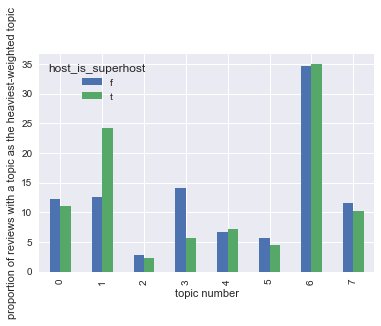

In [33]:
sns.set()
_ = sh_topic_percent2.plot.bar()
plt.xlabel('topic number')
plt.ylabel('proportion of reviews with a topic as the heaviest-weighted topic')
plt.show()

It appears that topic 1 (feelings) occur in reviews for superhosts more often than in reviews for non-superhosts. <br>
Topic 3 (issues/problems) occur in reviews for superhosts less often than in reviews for non-superhosts.

### Sentiment analysis 

In [45]:
sentiment = SentimentIntensityAnalyzer()
# calculate and save polarity scores for each review
polarity_scores = [sentiment.polarity_scores(review) for review in text_use['comments']]

In [46]:
polarity_scores[:5]

[{'compound': 0.9492, 'neg': 0.034, 'neu': 0.726, 'pos': 0.241},
 {'compound': 0.8932, 'neg': 0.0, 'neu': 0.64, 'pos': 0.36},
 {'compound': 0.8225, 'neg': 0.0, 'neu': 0.482, 'pos': 0.518},
 {'compound': 0.7233, 'neg': 0.0, 'neu': 0.792, 'pos': 0.208},
 {'compound': 0.6249, 'neg': 0.0, 'neu': 0.423, 'pos': 0.577}]

In [47]:
# save each of the four polarity scores - compound, negativity, neutrality, positivity in master dataframe
text_use1 = text_use.copy()
text_use1['compound'] = [score['compound'] for score in polarity_scores]
text_use1['negativity'] = [score['neg'] for score in polarity_scores]
text_use1['neutrality'] = [score['neu'] for score in polarity_scores]
text_use1['positivity'] = [score['pos'] for score in polarity_scores]

In [48]:
text_use1[:5]

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating,auto_posting,en,cleaned_data,review_length,compound,negativity,neutrality,positivity
0,7441144,"Pretty nice, quiet, cozy place to stay. Toilet...",f,$50.00,5,88.0,no,yes,"[pretty, nice, quiet, cozy, place, stay, toile...",38,0.9492,0.034,0.726,0.241
1,7441144,The host was extremely welcoming and obliging....,f,$50.00,5,88.0,no,yes,"[host, extremely, welcome, oblige, neighborhoo...",14,0.8932,0.000,0.640,0.360
2,7441144,Nice and easy stay - with good accommodations ...,f,$50.00,5,88.0,no,yes,"[nice, easy, stay, good, accommodation, especi...",8,0.8225,0.000,0.482,0.518
3,7441144,The host has been very accommodating and helpf...,f,$50.00,5,88.0,no,yes,"[host, accommodate, helpful, description, ad, ...",10,0.7233,0.000,0.792,0.208
4,7441144,It's a great quiet stay.,f,$50.00,5,88.0,no,yes,"[great, quiet, stay]",3,0.6249,0.000,0.423,0.577


#### Compare sentiment scores of reviews for superhosts and nonsuperhosts

In [49]:
text_use1['host_is_superhost'] = text_use1['host_is_superhost'].astype('category')

In [50]:
# ecdf function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

compound sentiment score

In [55]:
sh_compound = text_use1['compound'][text_use1['host_is_superhost']=='t']
nsh_compound = text_use1['compound'][text_use1['host_is_superhost']=='f']

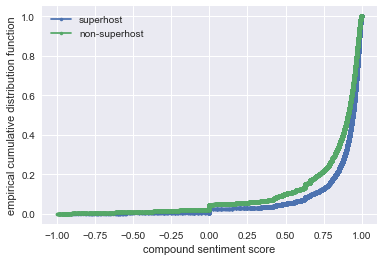

In [56]:
# plot ecdf of compound sentiment score for superhost vs non-superhost
x_sh, y_sh = ecdf(sh_compound)
x_nsh, y_nsh = ecdf(nsh_compound)
_ = plt.plot(x_sh, y_sh, marker='.', linestyle=None)
_ = plt.plot(x_nsh, y_nsh, marker='.', linestyle=None)
plt.legend(('superhost', 'non-superhost'), loc='upper left')
_ = plt.xlabel('compound sentiment score')
_ = plt.ylabel('empirical cumulative distribution function')
plt.show()

Larger proportion of reviews for superhosts have high sentiment scores than reviews for non-superhosts, but the difference seems quite small. <br>
The sentiment analyzer may not work well with airbnb review data. 

### Use features of reviews to predict superhost/non-superhost status <br>
May be used as a sentiment classifier for airbnb reviews.

In [36]:
# get target variable (change host status to 1 and 0) and feature variable
y = np.where(text_use['host_is_superhost']=='t', 1, 0)
X = text_use['comments']

In [37]:
# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Vectorize words with countvectorizer

In [38]:
# instantiate count vectorizer
count_vectorizer = CountVectorizer(stop_words='english')
# create term document matrix for training and test data
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

Train and test naive bayes classifier

In [41]:
# instatiate classifier
nb_classifier = MultinomialNB()
# fit classifier to training data
nb_classifier.fit(count_train, y_train)

# make prediction on test data 
pred = nb_classifier.predict(count_test)
# metrics
accuracy = metrics.accuracy_score(y_test, pred)
print(accuracy)
cm = metrics.confusion_matrix(y_test, pred, labels=[0,1])
print(cm)

0.789765071182
[[17985  3021]
 [ 4156  8976]]


Most predictive features?

In [44]:
feature_names = count_vectorizer.get_feature_names()
# zip feature names with coefficient array, and sort feature with weights
feature_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))
# features with highest weights for superhost
feature_with_weights[-30:]

[(-5.4901991565364039, 'area'),
 (-5.4772175808972516, 'quiet'),
 (-5.4658181984087566, 'wonderful'),
 (-5.4387026307692299, 'restaurants'),
 (-5.4193110631473935, 'helpful'),
 (-5.3599760758744743, 'beautiful'),
 (-5.3244190001021146, 'just'),
 (-5.3158457693916272, 'good'),
 (-5.2543606857409468, 'neighborhood'),
 (-5.1831073740331703, 'close'),
 (-5.1735419912907901, 'walk'),
 (-5.1453828672079567, 'time'),
 (-5.118795811583416, 'definitely'),
 (-5.0519816921195559, 'really'),
 (-5.0474957032881207, 'perfect'),
 (-4.9389139732597727, 'easy'),
 (-4.909892975343535, 'home'),
 (-4.9064858170219221, 'house'),
 (-4.8788504827775565, 'recommend'),
 (-4.7925614925852145, 'room'),
 (-4.719693113177458, 'nice'),
 (-4.7120630647826367, 'host'),
 (-4.6971067936679862, 'comfortable'),
 (-4.4388538024972064, 'location'),
 (-4.3616485083513226, 'apartment'),
 (-4.3462686087912541, 'clean'),
 (-4.0621076667380525, 'boston'),
 (-3.9548692162560268, 'place'),
 (-3.8994599513257988, 'stay'),
 (-3.766